# FiLM Gamma and Beta Distribution Analysis

This notebook loads one or more FiLM analysis JSON outputs produced by `film_analysis_simple.py` and visualizes the distributions of the FiLM modulation parameters:

- Gamma (derived as `scale - 1`) using per-feature mean values stored under `scale_stats.feature_mean`.
- Beta (per-feature mean bias) using `bias_stats.feature_mean`.

Because the original JSON stores only per-feature means aggregated over (time, batch) for each sample, histograms here reflect the distribution across (samples × features). If you need true element-wise (time-step level) distributions, see the optional patch section at the end to extend the exporter.

Sections:
1. Configuration & Imports
2. Path selection
3. Utility loaders
4. Load JSONs
5. Validation
6. Extraction of gamma/beta feature means
7. DataFrame assembly
8. Summary statistics
9. Histograms: gamma means
10. Histograms: |gamma| & beta
11. Overlay by model
12. Per-feature box/violin
13. Scatter gamma vs beta
14. Extreme features
15. Interactive feature explorer
16. Save figures & export CSV
17. Optional upstream patch for raw element-wise storage


In [1]:
# 1. Configuration & Imports
import os, json, glob, math, itertools, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: statistical tests
from scipy import stats

# Optional: interactive widgets (may not be installed)
try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 110
np.random.seed(42)

RESULTS_DIR = Path("results")
print(f"Using results directory: {RESULTS_DIR.resolve()}")

Using results directory: /root/masters-thesis/film_analysis/results


In [2]:
# 2. Define Paths and Select JSON Result Files
pattern = str(RESULTS_DIR / "film_analysis_*_mha_film.json")
found_files = glob.glob(pattern)
print(f"Discovered {len(found_files)} files:")
for fp in found_files:
    print(" -", fp)

# Manual override: specify subset or ordering here if desired
SELECTED_FILES = found_files  # Or e.g., [found_files[0]]
if not SELECTED_FILES:
    warnings.warn("No result JSON files found. Populate results/ first.")
SELECTED_FILES

Discovered 2 files:
 - results/film_analysis_violin_mha_film.json
 - results/film_analysis_vocal_mha_film.json


['results/film_analysis_violin_mha_film.json',
 'results/film_analysis_vocal_mha_film.json']

In [3]:
# 3. Utility Functions to Load and Normalize Result Structures

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)


def iterate_analyses(results_dict):
    """Yield (artist, song, analysis_dict). analysis_dict may be None."""
    for artist, songs in results_dict.items():
        for song, analyses in songs.items():
            for analysis in analyses:
                yield artist, song, analysis


def infer_model_tag(filename):
    base = os.path.basename(filename)
    # expecting film_analysis_<model>_mha_film.json
    parts = base.split('_')
    for token in parts:
        if token.lower() in ("vocal", "violin"):
            return token.lower()
    return "unknown"

print("Utility functions defined.")

Utility functions defined.


In [4]:
# 4. Load All Selected FiLM Analysis JSON Files Into a Unified List
raw_records = []
for fp in SELECTED_FILES:
    try:
        data = load_json(fp)
    except Exception as e:
        warnings.warn(f"Failed to load {fp}: {e}")
        continue
    model_tag = infer_model_tag(fp)
    count = 0
    for artist, song, analysis in iterate_analyses(data):
        raw_records.append({
            'model': model_tag,
            'artist': artist,
            'song': song,
            'analysis': analysis
        })
        count += 1
    print(f"Loaded {count} analyses from {fp} (model={model_tag})")
len(raw_records)

Loaded 3070 analyses from results/film_analysis_violin_mha_film.json (model=violin)
Loaded 20459 analyses from results/film_analysis_vocal_mha_film.json (model=vocal)


23529

In [5]:
# 5. Validate Presence of Required Keys and Handle Missing Data
valid_records = []
skipped_missing = 0
for rec in raw_records:
    a = rec['analysis']
    if a is None:
        skipped_missing += 1
        continue
    try:
        if 'scale_stats' not in a or 'feature_mean' not in a['scale_stats']:
            skipped_missing += 1; continue
        if 'bias_stats' not in a or 'feature_mean' not in a['bias_stats']:
            skipped_missing += 1; continue
        valid_records.append(rec)
    except Exception:
        skipped_missing += 1
print(f"Valid analyses: {len(valid_records)} / {len(raw_records)}; skipped={skipped_missing}")
if not valid_records:
    warnings.warn("No valid records to process.")

Valid analyses: 23393 / 23529; skipped=136


In [6]:
# 6. Extract Per-Sample Gamma (scale - 1) and Beta Feature Means
extracted = []
for rec in valid_records:
    a = rec['analysis']
    scale_feat = np.array(a['scale_stats']['feature_mean'], dtype=float)
    bias_feat = np.array(a['bias_stats']['feature_mean'], dtype=float)
    gamma_feat = scale_feat - 1.0
    abs_gamma_feat = np.abs(gamma_feat)
    model = rec['model']; artist = rec['artist']; song = rec['song']
    for idx, (g, b, ag) in enumerate(zip(gamma_feat, bias_feat, abs_gamma_feat)):
        extracted.append({
            'model': model,
            'artist': artist,
            'song': song,
            'feature_idx': idx,
            'gamma_mean': g,
            'beta_mean': b,
            'abs_gamma_mean': ag,
        })
len(extracted)

11977216

In [7]:
# 7. Assemble Aggregated DataFrame
import pandas as pd

df = pd.DataFrame(extracted)
if not df.empty:
    df['abs_beta_mean'] = df['beta_mean'].abs()
    display(df.head())
    print("Shape:", df.shape)
    print(df.isna().sum().sum(), "NaNs total")
else:
    warnings.warn("DataFrame is empty.")

df

,model,artist,song,feature_idx,gamma_mean,beta_mean,abs_gamma_mean,abs_beta_mean
0,violin,Archana Murali,Ee Vasudha,0,7.039917,-0.240328,7.039917,0.240328
1,violin,Archana Murali,Ee Vasudha,1,-6.729050,-1.359921,6.729050,1.359921
2,violin,Archana Murali,Ee Vasudha,2,5.922119,1.448433,5.922119,1.448433
3,violin,Archana Murali,Ee Vasudha,3,6.810974,0.296518,6.810974,0.296518
4,violin,Archana Murali,Ee Vasudha,4,-5.704300,0.333203,5.704300,0.333203


Shape: (11977216, 8)
0 NaNs total


,model,artist,song,feature_idx,gamma_mean,beta_mean,abs_gamma_mean,abs_beta_mean
0,violin,Archana Murali,Ee Vasudha,0,7.039917,-0.240328,7.039917,0.240328
1,violin,Archana Murali,Ee Vasudha,1,-6.729050,-1.359921,6.729050,1.359921
2,violin,Archana Murali,Ee Vasudha,2,5.922119,1.448433,5.922119,1.448433
3,violin,Archana Murali,Ee Vasudha,3,6.810974,0.296518,6.810974,0.296518
4,violin,Archana Murali,Ee Vasudha,4,-5.704300,0.333203,5.704300,0.333203
...,...,...,...,...,...,...,...,...
11977211,vocal,Yoga Keerthana,Triloka Mata,507,-4.936905,0.340737,4.936905,0.340737
11977212,vocal,Yoga Keerthana,Triloka Mata,508,4.015320,-0.246155,4.015320,0.246155
11977213,vocal,Yoga Keerthana,Triloka Mata,509,4.761688,0.358653,4.761688,0.358653
11977214,vocal,Yoga Keerthana,Triloka Mata,510,5.319748,0.638990,5.319748,0.638990


In [8]:
# 8. Compute Global Summary Statistics
if df.empty:
    print("No data to summarize")
else:
    def summarize(col):
        arr = df[col].values
        stats_dict = {
            'mean': float(np.mean(arr)),
            'std': float(np.std(arr)),
        }
        for p in [50, 75, 90, 95, 99]:
            stats_dict[f'p{p}'] = float(np.percentile(arr, p))
        return stats_dict
    gamma_stats = summarize('gamma_mean')
    abs_gamma_stats = summarize('abs_gamma_mean')
    beta_stats = summarize('beta_mean')
    print('Gamma mean stats:', gamma_stats)
    print('Abs Gamma stats:', abs_gamma_stats)
    print('Beta mean stats:', beta_stats)
    if df['model'].nunique() > 1:
        print('\nBy model:')
        for model, sub in df.groupby('model'):
            print(model, 'gamma_mean mean', sub['gamma_mean'].mean(), 'abs_gamma_mean mean', sub['abs_gamma_mean'].mean())

Gamma mean stats: {'mean': -0.0423732042231087, 'std': 5.1860589046806655, 'p50': -4.029315948486328, 'p75': 4.96185302734375, 'p90': 5.4244537353515625, 'p95': 5.9617919921875, 'p99': 7.668975830078125}
Abs Gamma stats: {'mean': 5.129903917228692, 'std': 0.7622914477124434, 'p50': 4.98345947265625, 'p75': 5.3132476806640625, 'p90': 5.8981781005859375, 'p95': 6.7174224853515625, 'p99': 8.140228271484375}
Beta mean stats: {'mean': 0.02074183166781802, 'std': 0.6662757371422164, 'p50': 0.025960328988730907, 'p75': 0.46048545837402344, 'p90': 0.8459930419921875, 'p95': 1.0759410858154297, 'p99': 1.5766443252563462}

By model:
violin gamma_mean mean 0.2824080248589377 abs_gamma_mean mean 6.44251057030484
vocal gamma_mean mean -0.09126929620718031 abs_gamma_mean mean 4.932289862287413


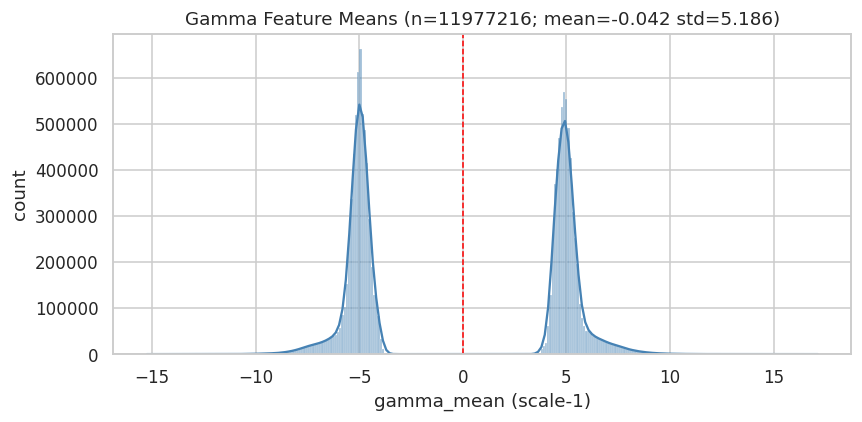

In [9]:
# 9. Plot Histogram: Gamma Feature Means (All Samples Flattened)
if df.empty:
    print("No data to plot")
else:
    data = df['gamma_mean'].values
    # Freedman–Diaconis bins
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    bin_width = 2 * iqr * (len(data) ** (-1/3)) if iqr > 0 else None
    if bin_width and bin_width > 0:
        bins = int(np.ceil((data.max() - data.min()) / bin_width))
        bins = max(10, min(300, bins))
    else:
        bins = 100
    plt.figure(figsize=(8,4))
    sns.histplot(data, bins=bins, kde=True, color='steelblue')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Gamma Feature Means (n={len(data)}; mean={data.mean():.3f} std={data.std():.3f})")
    plt.xlabel('gamma_mean (scale-1)')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

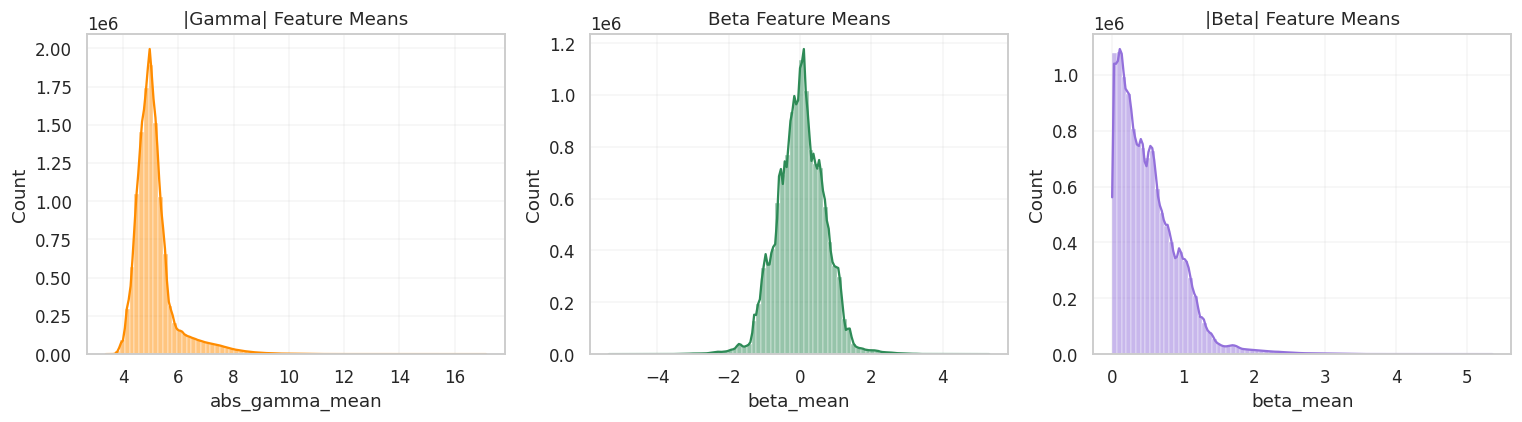

In [10]:
# 10. Plot Histograms: |Gamma| and Beta Means
if df.empty:
    print("No data to plot")
else:
    fig, axes = plt.subplots(1,3, figsize=(14,4))
    sns.histplot(df['abs_gamma_mean'], bins=80, kde=True, ax=axes[0], color='darkorange')
    axes[0].set_title('|Gamma| Feature Means')
    sns.histplot(df['beta_mean'], bins=80, kde=True, ax=axes[1], color='seagreen')
    axes[1].set_title('Beta Feature Means')
    sns.histplot(df['beta_mean'].abs(), bins=80, kde=True, ax=axes[2], color='mediumpurple')
    axes[2].set_title('|Beta| Feature Means')
    for ax in axes:
        ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

KS test violin vs vocal: stat=0.3840, p=0.00e+00


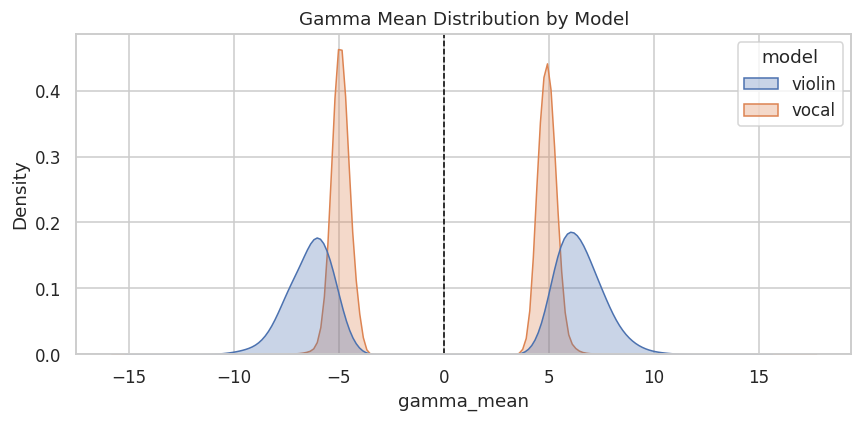

In [11]:
# 11. Overlay Vocal vs Violin (If Both Present)
if not df.empty and df['model'].nunique() > 1:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df, x='gamma_mean', hue='model', common_norm=False, fill=True, alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title('Gamma Mean Distribution by Model')
    plt.tight_layout()
    # KS test between first two models
    models = list(df['model'].unique())
    if len(models) >= 2:
        a = df.loc[df['model']==models[0], 'gamma_mean'].values
        b = df.loc[df['model']==models[1], 'gamma_mean'].values
        ks_stat, ks_p = stats.ks_2samp(a, b)
        print(f"KS test {models[0]} vs {models[1]}: stat={ks_stat:.4f}, p={ks_p:.2e}")
    plt.show()
else:
    print("Single model or no data; skipping overlay plot.")

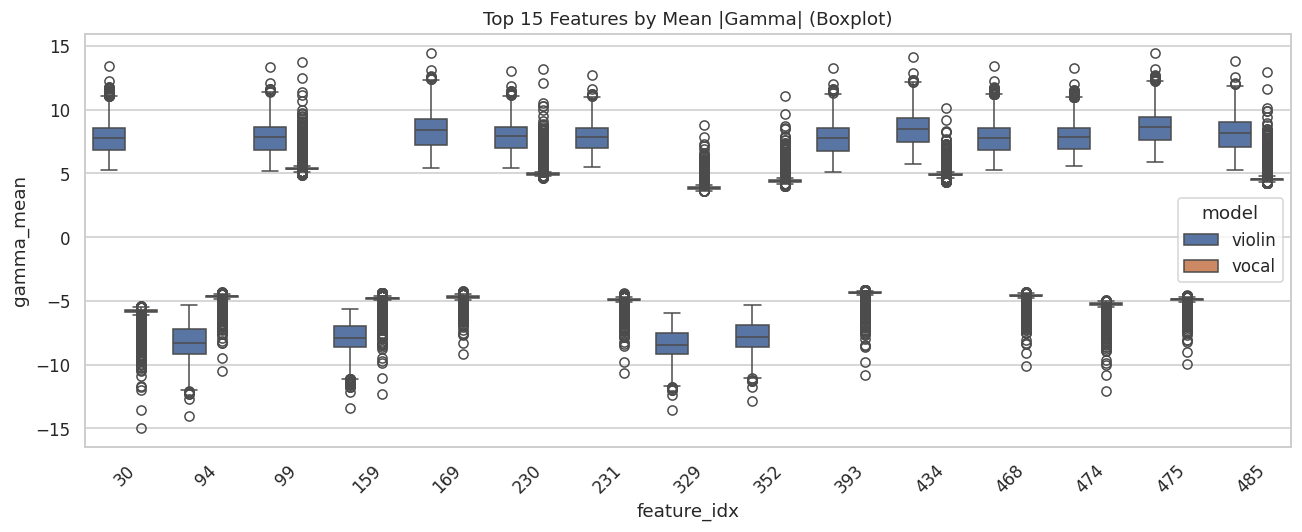

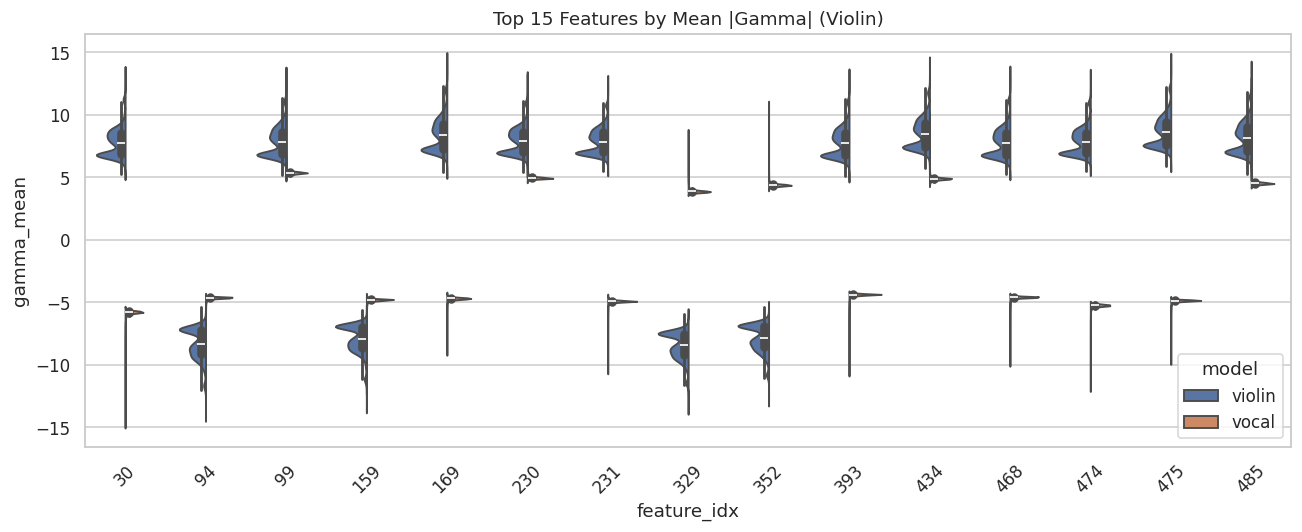

In [12]:
# 12. Per-Feature Distribution Plots (Box / Violin) for Top |Gamma|
if df.empty:
    print("No data to plot")
else:
    # Compute mean |gamma| per feature across samples per model
    topN = 15
    feat_rank = (df.groupby(['model','feature_idx'])['abs_gamma_mean']
                   .mean()
                   .reset_index()
                   .sort_values('abs_gamma_mean', ascending=False))
    top_features = feat_rank.head(topN)['feature_idx'].unique().tolist()
    sub = df[df['feature_idx'].isin(top_features)]
    plt.figure(figsize=(12,5))
    sns.boxplot(data=sub, x='feature_idx', y='gamma_mean', hue='model')
    plt.title(f'Top {topN} Features by Mean |Gamma| (Boxplot)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12,5))
    sns.violinplot(data=sub, x='feature_idx', y='gamma_mean', hue='model', split=True)
    plt.title(f'Top {topN} Features by Mean |Gamma| (Violin)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

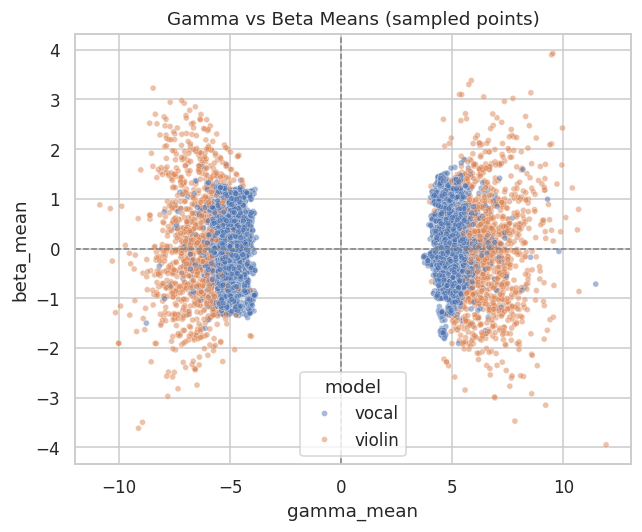

Model violin: Pearson=-0.0685, Spearman=-0.0597
Model vocal: Pearson=0.0471, Spearman=0.0361


In [13]:
# 13. Scatter Plots: Gamma vs Beta Feature Means
if df.empty:
    print("No data to plot")
else:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df.sample(min(len(df), 20000), random_state=42), x='gamma_mean', y='beta_mean', hue='model', alpha=0.5, s=15)
    plt.axvline(0, color='grey', lw=1, ls='--')
    plt.axhline(0, color='grey', lw=1, ls='--')
    plt.title('Gamma vs Beta Means (sampled points)')
    plt.tight_layout()
    plt.show()
    # Correlations
    for model, sub in df.groupby('model'):
        pear = stats.pearsonr(sub['gamma_mean'], sub['beta_mean'])[0]
        spear = stats.spearmanr(sub['gamma_mean'], sub['beta_mean'])[0]
        print(f"Model {model}: Pearson={pear:.4f}, Spearman={spear:.4f}")

Top features by |gamma|:


,model,feature_idx,mean_abs_gamma,mean_abs_beta
475,violin,475,8.657367,0.549574
434,violin,434,8.515398,1.106576
329,violin,329,8.482147,1.138241
169,violin,169,8.404660,2.866898
94,violin,94,8.314106,1.426560
485,violin,485,8.163240,0.333123
230,violin,230,7.938614,1.066541
159,violin,159,7.924385,0.351451
231,violin,231,7.895333,0.133450
352,violin,352,7.872943,0.668069


Top features by |beta|:


,model,feature_idx,mean_abs_gamma,mean_abs_beta
305,violin,305,5.065791,2.904847
169,violin,169,8.404660,2.866898
107,violin,107,6.958051,2.819539
64,violin,64,7.417124,2.811264
377,violin,377,6.543925,2.714581
478,violin,478,5.299851,2.665404
175,violin,175,5.390478,2.560063
469,violin,469,6.605557,2.520552
497,violin,497,6.646545,2.497303
505,violin,505,7.420914,2.456301


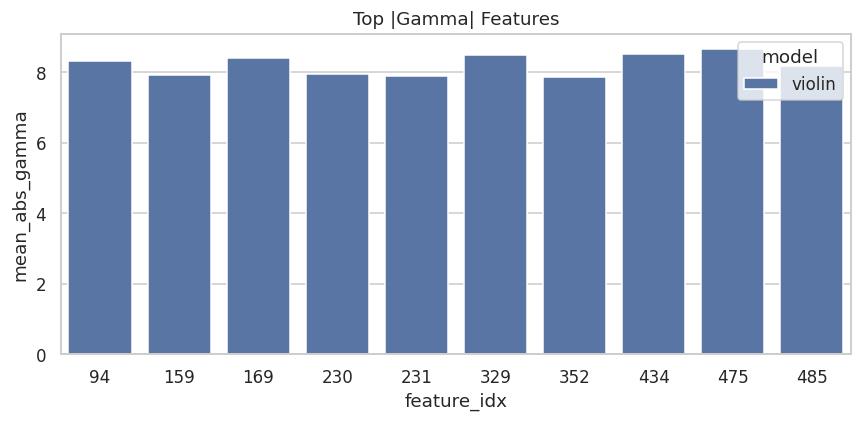

In [14]:
# 14. Identify Most Extreme Features
if df.empty:
    print("No data to analyze")
else:
    group = df.groupby(['model','feature_idx'])
    feature_summary = group.agg(mean_abs_gamma=('abs_gamma_mean','mean'), mean_abs_beta=('abs_beta_mean','mean')).reset_index()
    topK = 10
    top_gamma = feature_summary.sort_values('mean_abs_gamma', ascending=False).head(topK)
    top_beta = feature_summary.sort_values('mean_abs_beta', ascending=False).head(topK)
    print('Top features by |gamma|:')
    display(top_gamma)
    print('Top features by |beta|:')
    display(top_beta)
    plt.figure(figsize=(8,4))
    sns.barplot(data=top_gamma, x='feature_idx', y='mean_abs_gamma', hue='model')
    plt.title('Top |Gamma| Features')
    plt.tight_layout(); plt.show()

In [ ]:
# 15. Optional: Interactive Feature Explorer
if HAS_WIDGETS and not df.empty:
    feature_max = int(df['feature_idx'].max())
    model_options = ['all'] + sorted(df['model'].unique().tolist())
    feat_slider = widgets.IntSlider(value=0, min=0, max=feature_max, step=1, description='feature')
    model_dd = widgets.Dropdown(options=model_options, value='all', description='model')
    bins_slider = widgets.IntSlider(value=60, min=10, max=300, step=10, description='bins')

    def update(feature_idx, model, bins):
        subset = df[df['feature_idx']==feature_idx]
        if model != 'all':
            subset = subset[subset['model']==model]
        if subset.empty:
            print('No data for selection'); return
        plt.figure(figsize=(7,3))
        sns.histplot(subset['gamma_mean'], bins=bins, kde=True, color='steelblue')
        plt.axvline(0, color='red', ls='--')
        plt.title(f'Gamma Mean Distribution Feature {feature_idx} (model={model})')
        plt.tight_layout(); plt.show()
    widgets.interact(update, feature_idx=feat_slider, model=model_dd, bins=bins_slider)
else:
    print("ipywidgets not available or no data; skipping interactive section.")

In [ ]:
# 16. Save Figures and Export Aggregated CSV
OUTPUT_DIR = RESULTS_DIR / 'film_plots'
OUTPUT_DIR.mkdir(exist_ok=True)
print('Saving future figures to', OUTPUT_DIR)

# Example: re-generate a key figure and save
if not df.empty:
    plt.figure(figsize=(8,4))
    sns.histplot(df['gamma_mean'], bins=120, kde=True)
    plt.title('Gamma Feature Means (All)')
    plt.tight_layout()
    fig_path = OUTPUT_DIR / 'gamma_feature_means_hist.png'
    plt.savefig(fig_path)
    print('Saved', fig_path)
    df.to_csv(OUTPUT_DIR / 'film_gamma_beta_feature_means.csv', index=False)
    print('Exported CSV with shape', df.shape)
else:
    print('No data to save.')

### 17. Optional Upstream Patch: Storing Raw Element-wise Gamma/Beta

To enable true element-wise histograms (instead of per-feature means), modify `analyze_film_modulation` in `film_analysis_simple.py` right after computing `raw_gamma_np` / `raw_beta_np`:

```python
# WARNING: This can explode JSON size. Consider subsampling.
if debug and debug_file_handle is not None:
    # e.g., random subsample up to 5000 elements
    flat_gamma = raw_gamma_np.flatten()
    flat_beta = raw_beta_np.flatten()
    if flat_gamma.size > 5000:
        sel = np.random.choice(flat_gamma.size, 5000, replace=False)
        flat_gamma = flat_gamma[sel]
        flat_beta = flat_beta[sel]
    dbg['gamma_sample'] = flat_gamma.tolist()
    dbg['beta_sample'] = flat_beta.tolist()
```

Then re-run the analysis with `--debug_film` and adapt this notebook to parse those `gamma_sample` / `beta_sample` arrays for finer-grained plots.